*The Extinction Status of Psittaciformes*
================
**This file analyzes the Extinction Status of the order of Psittaciformes (Parrots)**


Research Question:

Investigate if there's a correlation between the physical characteristics of bird species, their natural environments, and their conservation status.

What roles do geographical locations play in the conservation status of bird species?

What roles do geographical locations play in the morphological traits of bird species?

Is there is a relationship between morphological traits and conservation status of bird species?

In [2]:
pip install geopandas matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd


In [4]:
df = pd.read_csv('../dataset/Psittaciformes.csv',
                 on_bad_lines='skip',
                 encoding='utf-8',
                 dtype=str,  # Read all as string first
                 skip_blank_lines=True,
                 header=0,
                 skipinitialspace=True)

In [5]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(df['redlistCategory'].unique())

['Endangered' 'Least Concern' 'Near Threatened' 'Vulnerable'
 'Critically Endangered' 'Extinct in the Wild']


In [6]:
categories = {
    'Trade': ['trade'],
    'Habitat Loss': ['habitat', 'loss', 'forest', 'areas'],
    'Climate Change': ['cyclones', 'natural', 'climate'],
    'Diseases': ['avian', 'malaria'],
    'Predation': ['predators'],
    'Human Activity': ['hunting', 'logging', 'agriculture'],
    'Pollution': ['pollution'],
}


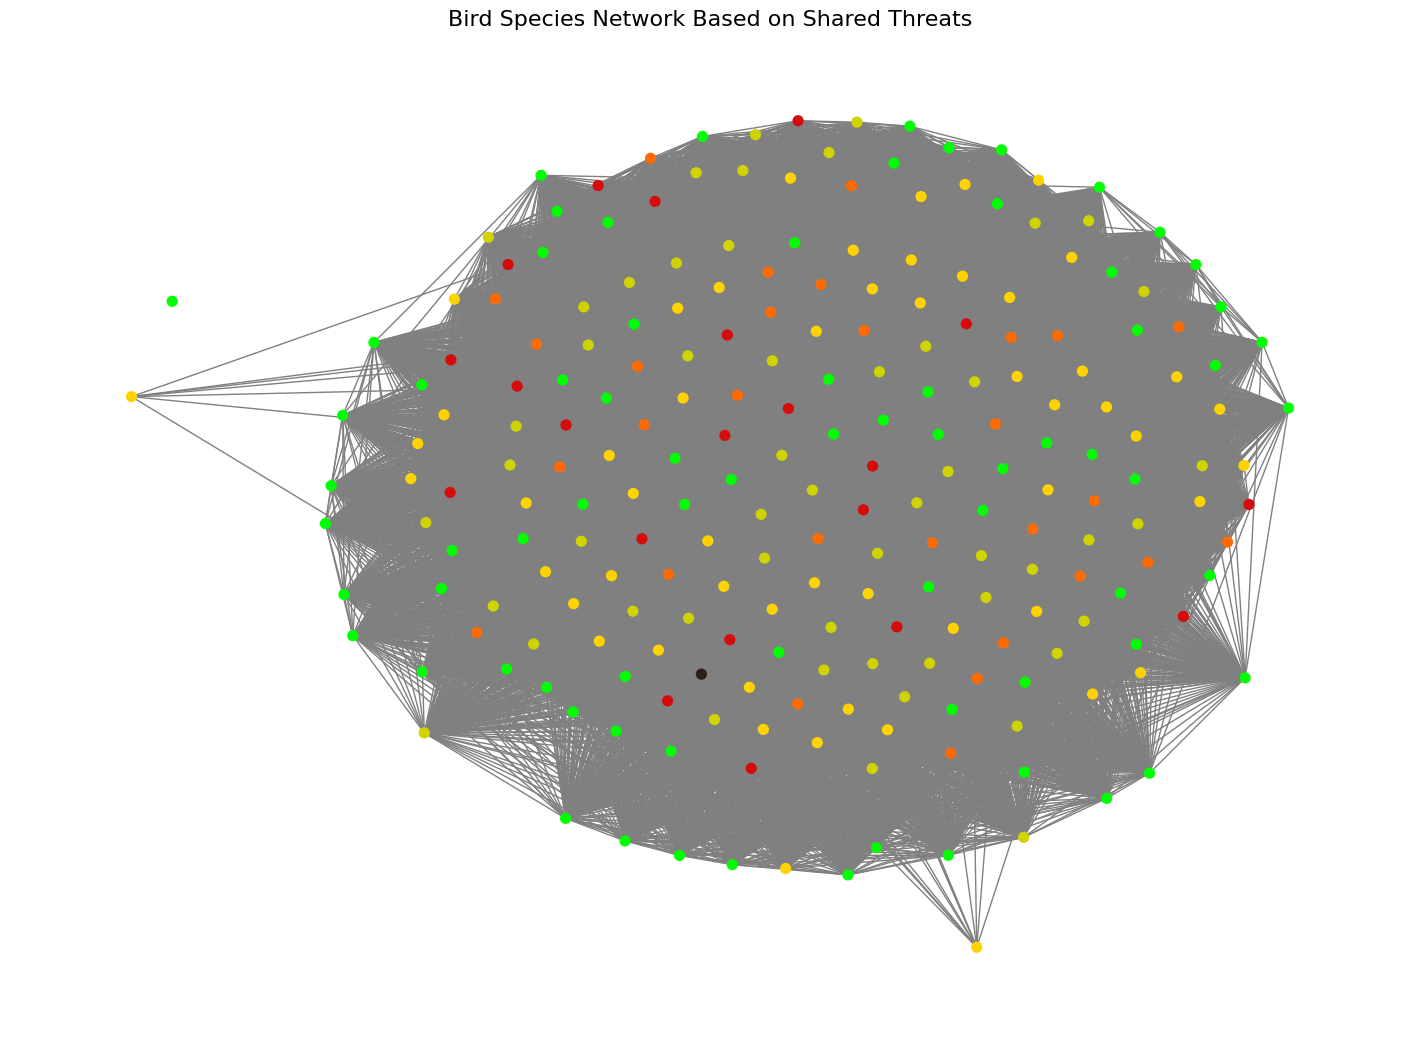

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter relevant columns and convert extinction status to color-coded categories
columns_needed = ['scientificName', 'threats', 'redlistCategory']
network_data = df[columns_needed].dropna()

# Define colors for extinction status
colors = {
    'Least Concern': '#00FF00',        
    'Vulnerable': '#FFD300',          
    'Near Threatened': '#CFD300',
    'Endangered': '#FF6B00',          
    'Critically Endangered': '#D60B0B',
    'Extinct in the Wild': '#2D1F15',  
    'Extinct': '#000000',              
}

# Initialize the graph
G = nx.Graph()

def categorize_threat(threat, category_keywords):
    return any(keyword in threat.lower() for keyword in category_keywords)

# Add nodes for each bird with color based on extinction status
for _, row in network_data.iterrows():
    G.add_node(row['scientificName'], color=colors[row['redlistCategory']])

# Add edges if two birds share at least one common threat
for i, row1 in network_data.iterrows():
    for j, row2 in network_data.iterrows():
        if i < j:  # Avoid duplicate comparisons and self-loops
            threats1 = set()
            for category, keywords in categories.items():
                if categorize_threat(row1['threats'], keywords):
                    threats1.add(category)

            threats2 = set()
            for category, keywords in categories.items():
                if categorize_threat(row2['threats'], keywords):
                    threats2.add(category)
            # Check if there is at least one common threat
            common_threats = threats1.intersection(threats2)
            if common_threats:
                G.add_edge(row1['scientificName'], row2['scientificName'])


# Visualize the network
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
pos = nx.spring_layout(G, k=8, iterations=200)  # Compute layout for visualization

plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='gray', font_size=10, font_weight='bold', node_size=50)
plt.title("Bird Species Network Based on Shared Threats", fontsize=16)
plt.show()


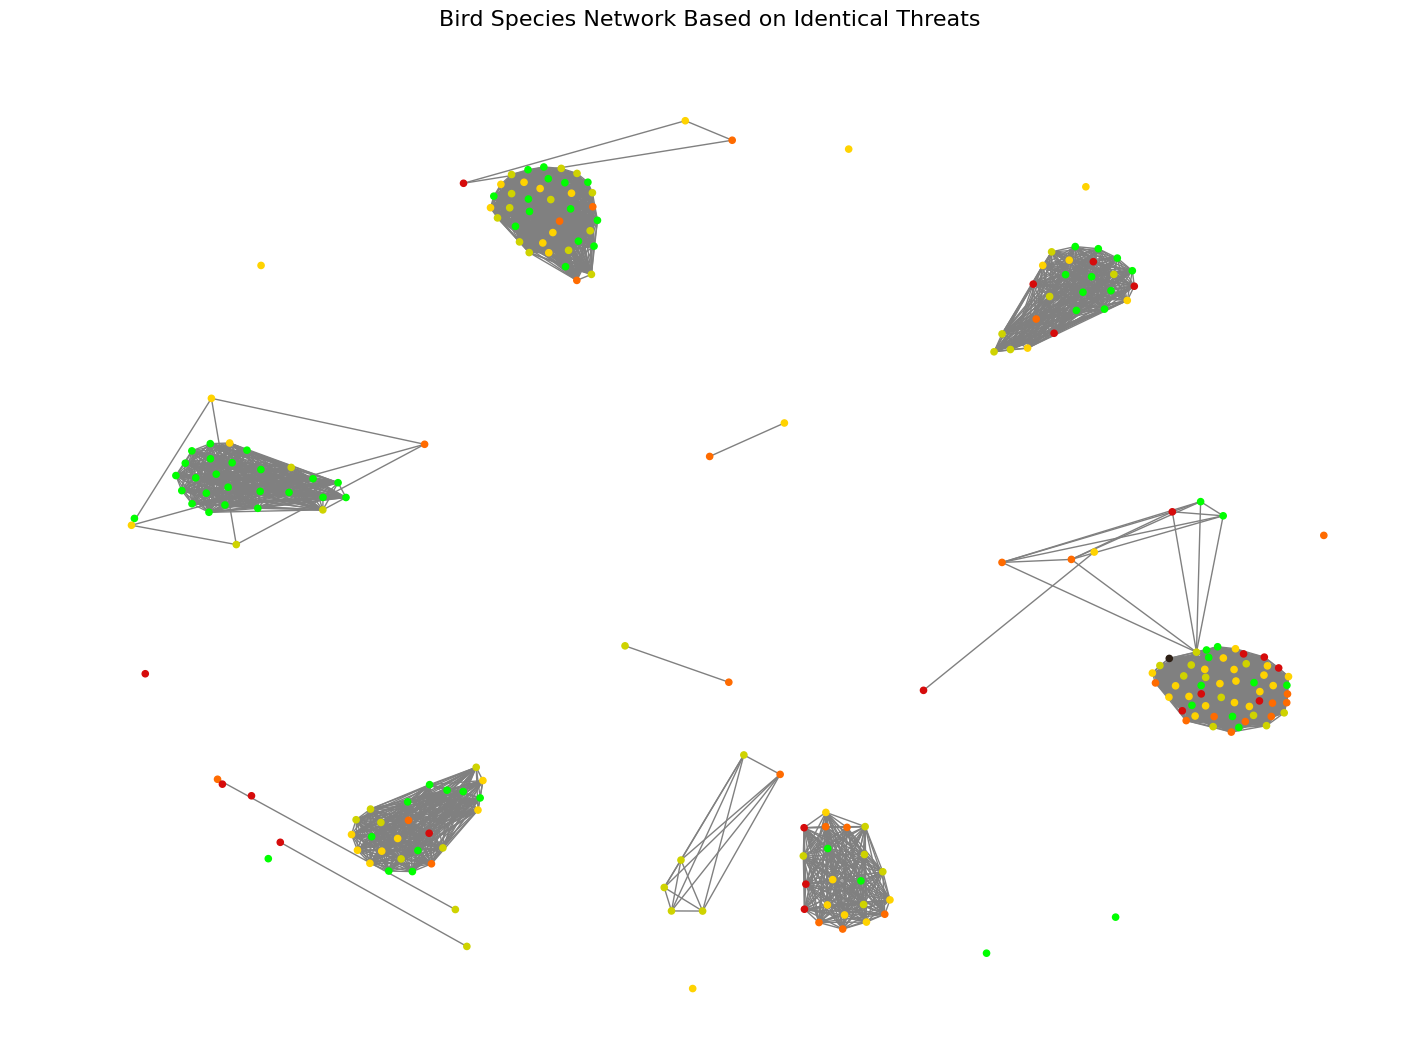

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Filter relevant columns and convert extinction status to color-coded categories
columns_needed = ['scientificName', 'threats', 'redlistCategory']
network_data = df[columns_needed].dropna()

# Define colors for extinction status
colors = {
    'Least Concern': '#00FF00',        
    'Vulnerable': '#FFD300',          
    'Near Threatened': '#CFD300',
    'Endangered': '#FF6B00',          
    'Critically Endangered': '#D60B0B',
    'Extinct in the Wild': '#2D1F15',  
    'Extinct': '#000000',              
}

# Initialize the graph
G = nx.Graph()

def categorize_threat(threat, category_keywords):
    return any(keyword in threat.lower() for keyword in category_keywords)

# Add nodes for each bird with color based on extinction status
for _, row in network_data.iterrows():
    G.add_node(row['scientificName'], color=colors[row['redlistCategory']])

# Add edges only if the categorized threat lists are exactly the same
for i, row1 in network_data.iterrows():
    for j, row2 in network_data.iterrows():
        if i < j:  # Avoid duplicate comparisons and self-loops
            # Categorize threats for the first bird
            threats1 = set()
            for category, keywords in categories.items():
                if categorize_threat(row1['threats'], keywords):
                    threats1.add(category)

            # Categorize threats for the second bird
            threats2 = set()
            for category, keywords in categories.items():
                if categorize_threat(row2['threats'], keywords):
                    threats2.add(category)

            # Check if the categorized threat lists are exactly the same
            if threats1 == threats2:
                G.add_edge(row1['scientificName'], row2['scientificName'])

# Visualize the network
node_colors = [G.nodes[node]['color'] for node in G.nodes()]
pos = nx.spring_layout(G, k=1.2, iterations=200)  # Compute layout for visualization

plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='gray', font_size=10, font_weight='bold', node_size=20)
plt.title("Bird Species Network Based on Identical Threats", fontsize=16)
plt.show()


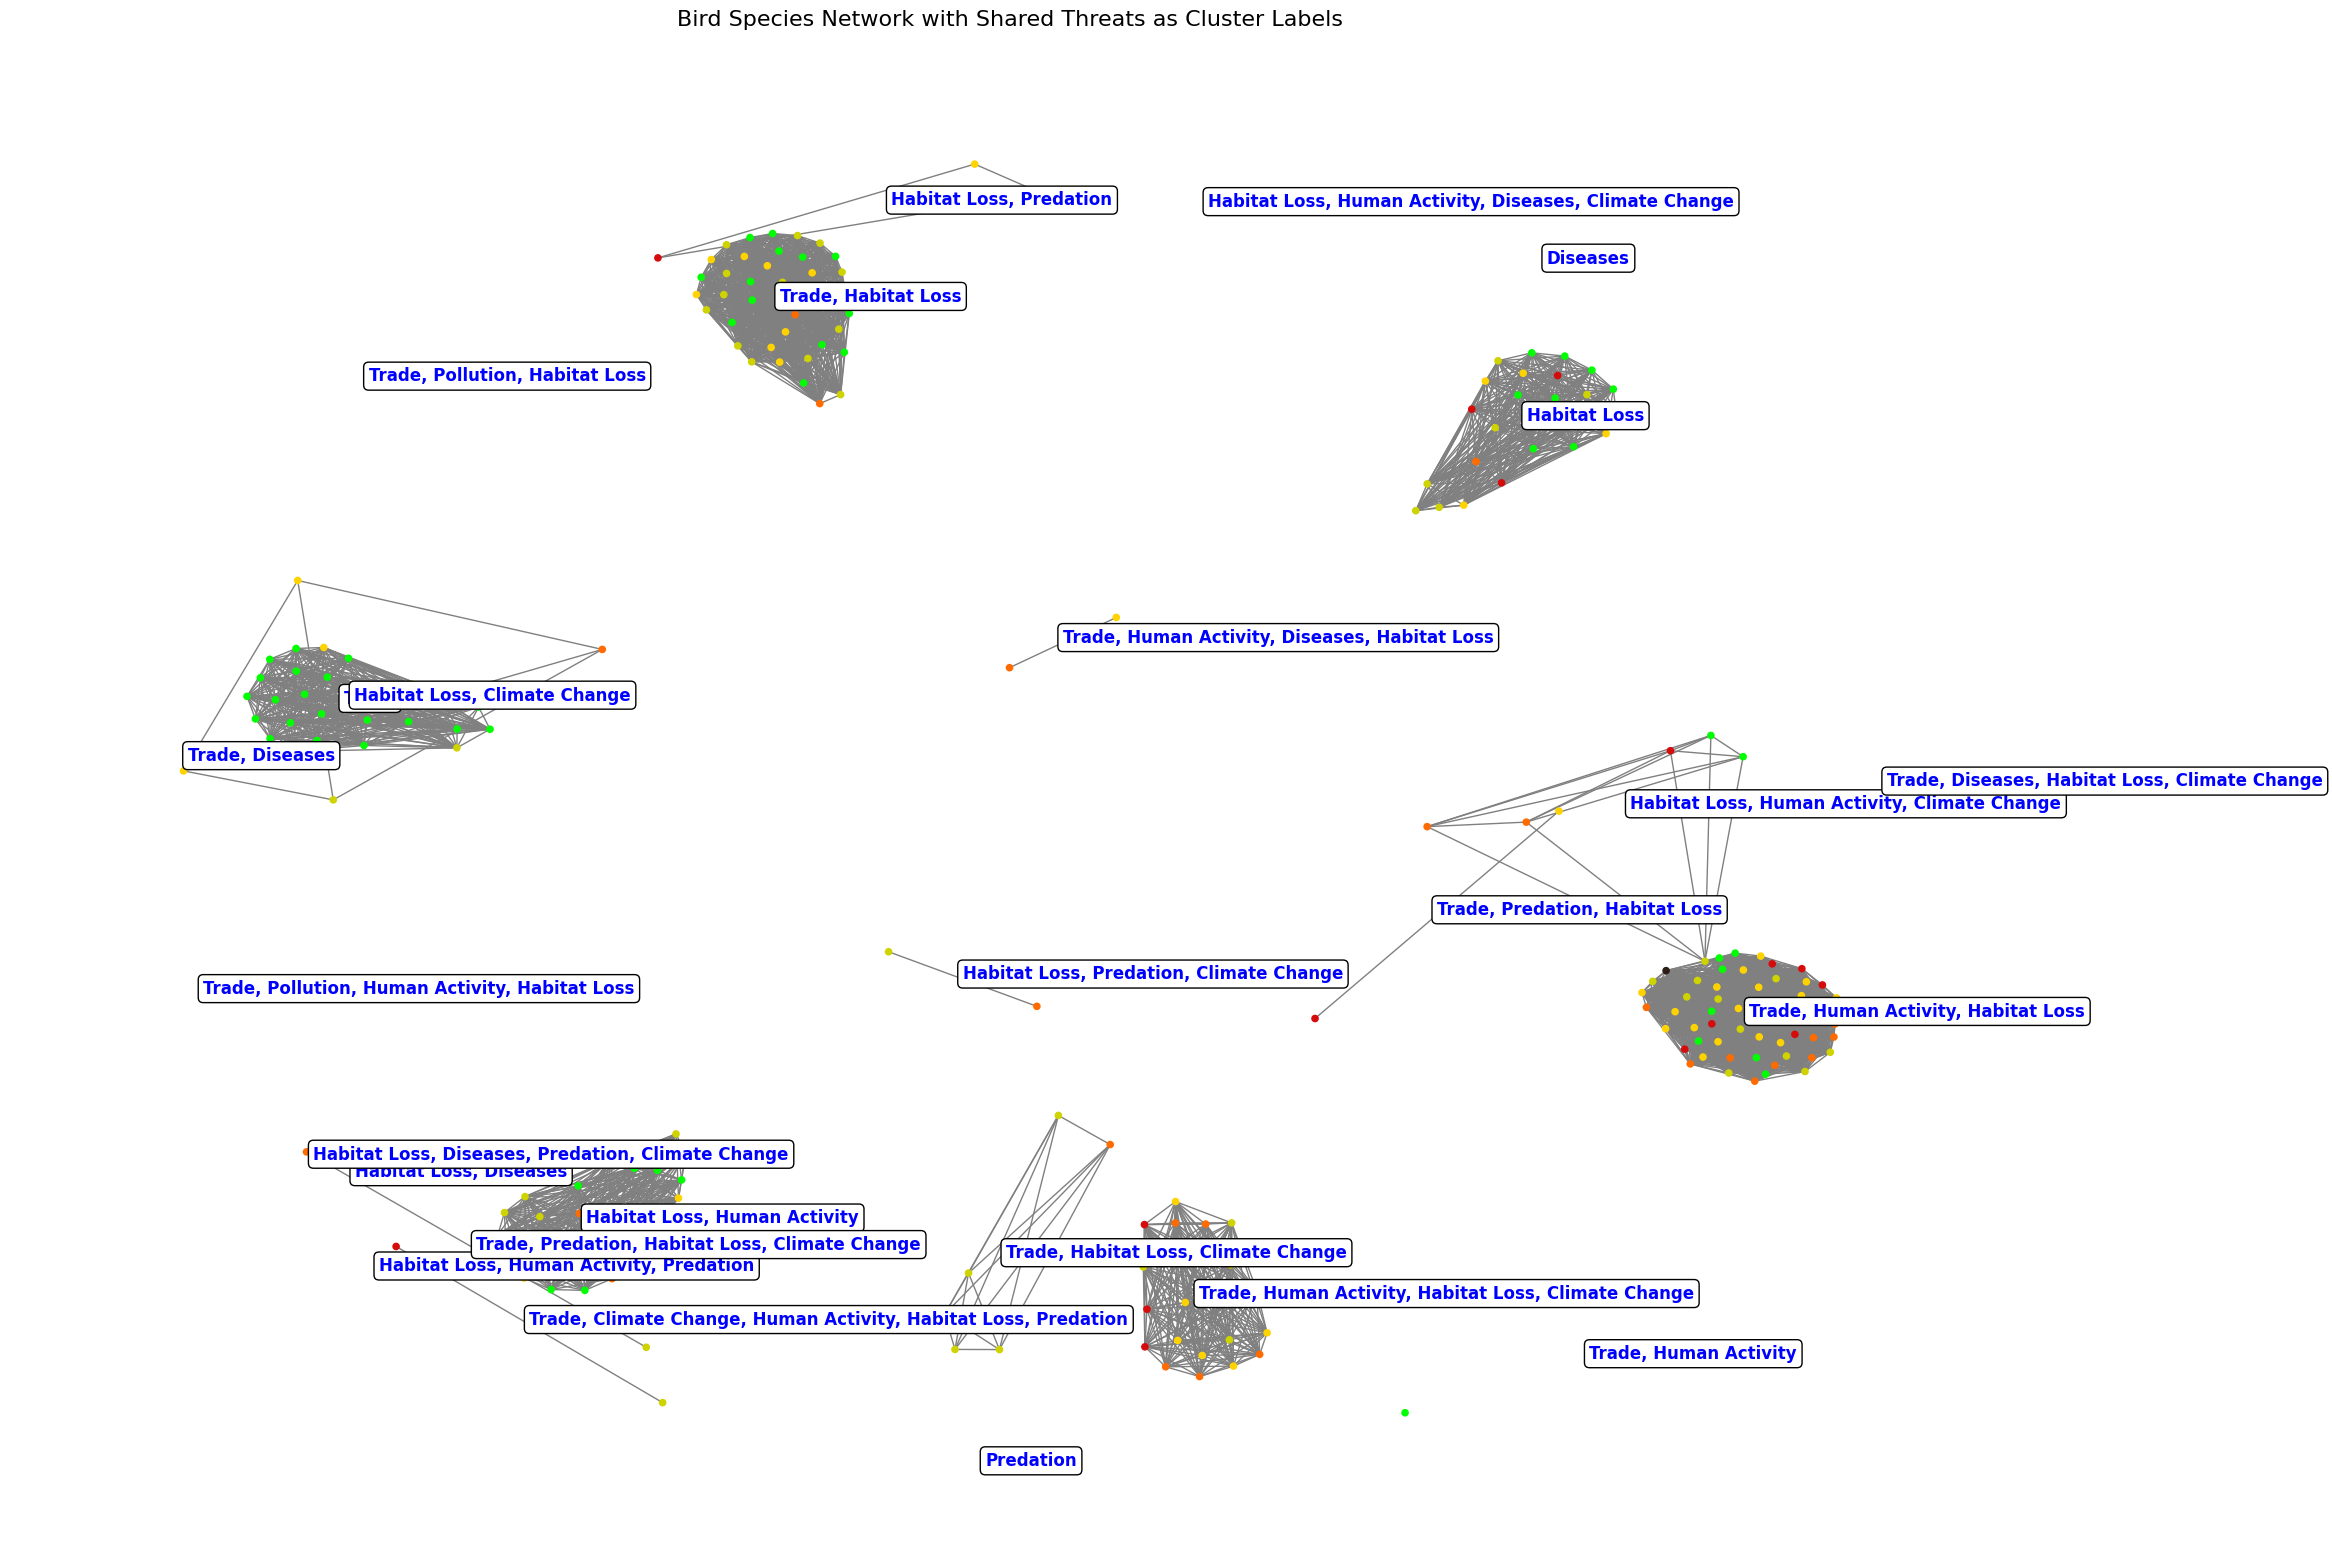

In [10]:
# Identify connected components (clusters)
connected_components = list(nx.connected_components(G))

# Calculate the shared threats for each cluster and determine label positions
cluster_labels = {}
for component in connected_components:
    # Get all birds in the current cluster
    cluster_nodes = list(component)
    
    # Find shared threats for the cluster
    shared_threats = set()
    for category, keywords in categories.items():
        # Check if all nodes in the cluster share the threat
        if all(categorize_threat(network_data.loc[network_data['scientificName'] == bird, 'threats'].iloc[0], keywords) for bird in cluster_nodes):
            shared_threats.add(category)
    
    # Compute the centroid position
    cluster_pos = [pos[node] for node in cluster_nodes]
    centroid_x = sum(x for x, y in cluster_pos) / len(cluster_pos)
    centroid_y = sum(y for x, y in cluster_pos) / len(cluster_pos)
    
    # Store the label as the list of shared threats
    cluster_labels[", ".join(shared_threats)] = (centroid_x, centroid_y)

# Visualize the network with cluster labels
plt.figure(figsize=(20,15))
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='gray', font_size=10, font_weight='bold', node_size=20)

# Add cluster labels to the plot
for label, (x, y) in cluster_labels.items():
    plt.text(x, y, label, fontsize=12, fontweight='bold', color='blue', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.title("Bird Species Network with Shared Threats as Cluster Labels", fontsize=16)
plt.show()


In [11]:
import pandas as pd
from collections import defaultdict

# Initialize a dictionary to store the contribution of each threat category
category_influence = defaultdict(lambda: defaultdict(int))

# Categorize threats for each bird and count their influence on the redlist categories
for _, row in network_data.iterrows():
    threat_categories = set()
    for category, keywords in categories.items():
        if categorize_threat(row['threats'], keywords):
            threat_categories.add(category)

    for category in threat_categories:
        category_influence[row['redlistCategory']][category] += 1

# Convert the nested dictionary to a DataFrame for better visualization
influence_df = pd.DataFrame(category_influence).fillna(0)

# Normalize the values to get proportions of influence
influence_df_normalized = influence_df.div(influence_df.sum(axis=0), axis=1)

# Display the DataFrame
print("Category Influence on Red List Colors:")
print(influence_df_normalized)


Category Influence on Red List Colors:
                Endangered  Near Threatened  Vulnerable  Least Concern  \
Trade             0.244186         0.289062    0.268116       0.393701   
Human Activity    0.220930         0.179688    0.246377       0.188976   
Habitat Loss      0.337209         0.390625    0.369565       0.370079   
Predation         0.034884         0.023438    0.021739       0.007874   
Climate Change    0.139535         0.117188    0.065217       0.031496   
Diseases          0.023256         0.000000    0.021739       0.007874   
Pollution         0.000000         0.000000    0.007246       0.000000   

                Critically Endangered  Extinct in the Wild  
Trade                        0.203390             0.333333  
Human Activity               0.220339             0.333333  
Habitat Loss                 0.355932             0.333333  
Predation                    0.067797             0.000000  
Climate Change               0.101695             0.000000  
Di

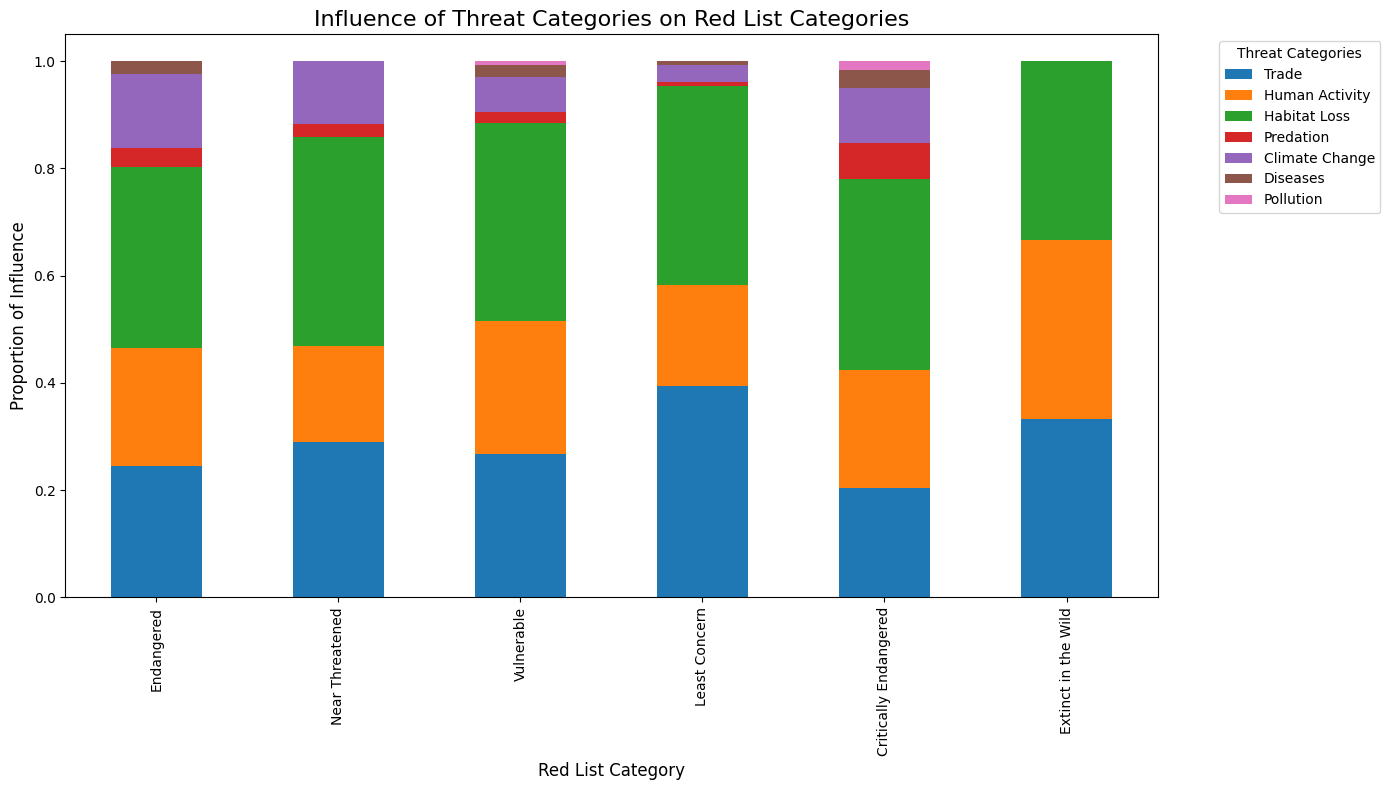

In [12]:
import matplotlib.pyplot as plt

# Plot the influence of threat categories on Red List categories
influence_df_normalized.T.plot(kind='bar', stacked=True, figsize=(14, 8))

# Add labels and title
plt.title("Influence of Threat Categories on Red List Categories", fontsize=16)
plt.xlabel("Red List Category", fontsize=12)
plt.ylabel("Proportion of Influence", fontsize=12)
plt.legend(title="Threat Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()


Normalized Threat Counts:
                Least Concern  Vulnerable  Near Threatened  Endangered  \
Trade                0.316456    0.234177         0.234177    0.132911   
Habitat Loss         0.236181    0.256281         0.251256    0.145729   
Climate Change       0.086957    0.195652         0.326087    0.260870   
Diseases             0.125000    0.375000         0.000000    0.250000   
Predation            0.071429    0.214286         0.214286    0.214286   
Human Activity       0.210526    0.298246         0.201754    0.166667   
Pollution            0.000000    0.500000         0.000000    0.000000   

                Critically Endangered  Extinct in the Wild  Extinct  
Trade                        0.075949             0.006329      0.0  
Habitat Loss                 0.105528             0.005025      0.0  
Climate Change               0.130435             0.000000      0.0  
Diseases                     0.250000             0.000000      0.0  
Predation                    0.

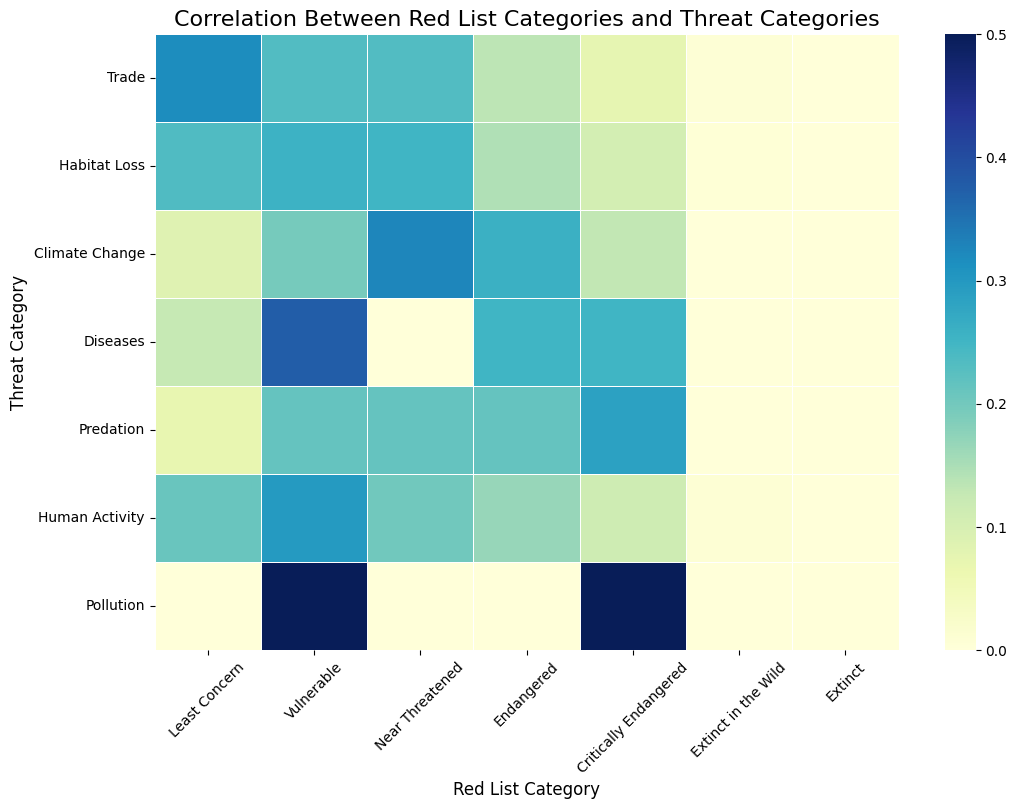

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np

# Initialize a dictionary to store counts of threats by redlist category
threat_counts = {category: {threat: 0 for threat in categories.keys()} for category in colors.keys()}

for _, row in network_data.iterrows():
    redlist_category = row['redlistCategory']
    if redlist_category in colors.keys():
        for threat_category, keywords in categories.items():
            if categorize_threat(row['threats'], keywords):
                threat_counts[redlist_category][threat_category] += 1

# Convert threat_counts to a DataFrame
threat_counts_df = pd.DataFrame(threat_counts).fillna(0)

# Compute row sums
row_sums = threat_counts_df.sum(axis=1)

# Normalize rows with non-zero sums
normalized_threat_counts = threat_counts_df.div(row_sums.where(row_sums != 0, np.nan), axis=0)

# Replace NaN values (from zero-sum rows) with 0
normalized_threat_counts = normalized_threat_counts.fillna(0)

print("Normalized Threat Counts:")
print(normalized_threat_counts)

# Plot the heatmap of threats vs. redlist categories
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_threat_counts, annot=False, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Correlation Between Red List Categories and Threat Categories", fontsize=16)
plt.xlabel("Red List Category", fontsize=12)
plt.ylabel("Threat Category", fontsize=12)
plt.xticks(rotation=45)
plt.show()



In [14]:
import networkx as nx
import json

def graphml_to_json_custom(graphml_path, json_path, threat_categories):
    """
    Convert GraphML to custom JSON format with separate node and edge lists
    and add a 'threat' category based on predefined keywords.
    """
    def categorize_threat(threat, category_keywords):
        return next((category for category, keywords in category_keywords.items()
                     if any(keyword in threat.lower() for keyword in keywords)), 'Unknown')

    # Read the GraphML file
    G = nx.read_graphml(graphml_path)

    # Create custom format
    graph_data = {
        'nodes': [],
        'edges': []
    }

    # Add nodes with attributes
    for node, attrs in G.nodes(data=True):
        node_data = {'id': node}
        node_data.update(attrs)
        # Add threat category if threat information exists
        if 'threat' in attrs:
            node_data['threat_category'] = categorize_threat(attrs['threat'], threat_categories)
        graph_data['nodes'].append(node_data)

    # Add edges with attributes
    for source, target, attrs in G.edges(data=True):
        edge_data = {
            'source': source,
            'target': target
        }
        edge_data.update(attrs)
        # Add threat category if threat information exists
        if 'threat' in attrs:
            edge_data['threat_category'] = categorize_threat(attrs['threat'], threat_categories)
        graph_data['edges'].append(edge_data)

    # Save to file
    with open(json_path, 'w') as f:
        json.dump(graph_data, f, indent=2)

    print(f"Nodes: {len(graph_data['nodes'])}")
    print(f"Edges: {len(graph_data['edges'])}")
    return graph_data

# Example usage
categories = {
    'Trade': ['trade'],
    'Habitat Loss': ['habitat', 'loss', 'forest', 'areas'],
    'Climate Change': ['cyclones', 'natural', 'climate'],
    'Diseases': ['avian', 'malaria'],
    'Predation': ['predators'],
    'Human Activity': ['hunting', 'logging', 'agriculture'],
    'Pollution': ['pollution'],
}

# Replace with actual paths
graphml_path = './morphology/morphological_parrot_network.graphml'
json_path = 'output.json'

# Generate JSON with threat categorization
graphml_to_json_custom(graphml_path, json_path, categories)


FileNotFoundError: [Errno 2] No such file or directory: './morphology/morphological_parrot_network.graphml'